100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 21523.89it/s]


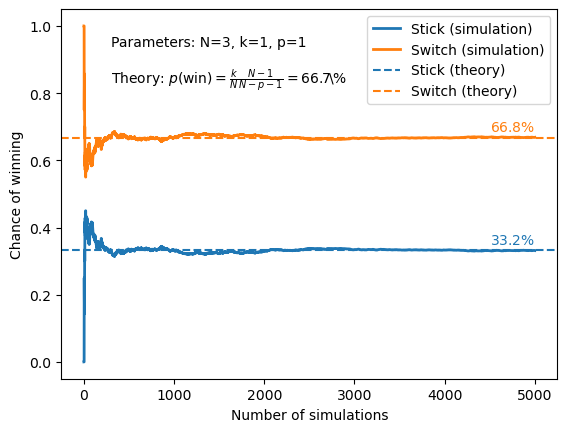

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from argparse import ArgumentParser

def run_sim( N, k, p ):
    """
    Run Monty Hall simulation

    Parameters
    ----------
    N : int
        The number of boxes
    k : int
        The number of boxes which contain prizes, must have k < N-1
    p : int
        The number of boxes which are revealed by the game show host
        after the initial selection, must have p < N-k
    """

    # make sure number of prizes is less than N-1
    if not k < (N-1):
        raise ValueError(f"Cannot have more prizes than number of boxes minus 1, k={k}, N={N}")

    # make sure number of door reveals is less than N-k
    if not p < (N-k):
        raise ValueError(f"Cannot have more box reveals than number of boxes minus number of prizes, p={p}, k={k}, N={N}")

    # box labels
    box_choices = np.arange(1, N+1, dtype=np.int32)

    # randomly choose which prizes boxes are in
    prizes = np.random.choice(box_choices, size=k, replace=False)

    # figure out which boxes are not prizes
    not_prizes = np.asarray( [ a for a in box_choices if a not in prizes ] )

    # randomly make an initial choice of box
    initial_choice = np.random.choice(box_choices, size=1)

    # possible reveal boxes
    poss_reveals = [ a for a in not_prizes if a not in initial_choice ]

    # randomly reveal other boxes not containing prize
    reveals = np.random.choice( poss_reveals, size=p,  replace=False )

    # which boxes could now be switched to
    switch_options = [ a for a in box_choices if a not in initial_choice and a not in reveals ]

    # pick a switch box
    switch_choice = np.random.choice( switch_options, size=1 )

    # let's run some checks we didn't make a mistake
    assert( len(box_choices) == len(prizes)+len(not_prizes) )
    assert( sorted(box_choices) == sorted( np.concatenate( [prizes, not_prizes] ) ) )

    # win outcome
    win_stick = initial_choice in prizes
    win_switch = switch_choice in prizes

    return win_stick, win_switch

def theory( N, k, p ):
    prob_win_switch = (k/N)*( (N-1)/(N-p-1) )
    prob_win_stick  = 1 - prob_win_switch
    return prob_win_stick, prob_win_switch

def run_ntrials( Ntrials, N, k, p, seed=None ):

    if seed:
        np.random.seed(seed)

    Nwin_stick  = 0
    Nwin_switch = 0

    stick_win_tracker = []
    switch_win_tracker = []

    for i in tqdm(range(Ntrials)):
        win_stick, win_switch = run_sim( N, k, p)
        if win_switch:
            Nwin_switch += 1
        else:
            Nwin_stick += 1

        stick_win_tracker.append( Nwin_stick )
        switch_win_tracker.append( Nwin_switch )

    stick_win_tracker = np.asarray( stick_win_tracker )
    switch_win_tracker = np.asarray( switch_win_tracker )

    fig, ax = plt.subplots()
    x = np.arange(1, Ntrials+1, 1)

    stick_win_frac = stick_win_tracker / x 
    switch_win_frac = switch_win_tracker / x

    res_stick = stick_win_frac[-1]
    res_switch = switch_win_frac[-1]

    # compute the theory line
    th_win_stick, th_win_switch = theory( N, k, p )
    
    ax.plot(x, stick_win_frac, lw=2, label='Stick (simulation)')
    ax.plot(x, switch_win_frac, lw=2, label='Switch (simulation)')
    ax.axhline( th_win_stick, c='C0', ls='--', label='Stick (theory)')
    ax.axhline( th_win_switch, c='C1', ls='--', label='Switch (theory)')
    ax.text(0.1,0.9, f'Parameters: N={N}, k={k}, p={p}', transform=ax.transAxes)
    ax.text(0.1,0.8, r'Theory: $p(\mathrm{win}) = \frac{k}{N}\frac{N-1}{N-p-1} = $'+f"{(100*((k/N)*((N-1)/(N-p-1)))):.3g}\%", transform=ax.transAxes)
    ax.text(Ntrials, res_stick+0.01, f'${100*res_stick:3.1f}\%$', color='C0', va='bottom', ha='right')
    ax.text(Ntrials, res_switch+0.01, f'${100*res_switch:3.1f}\%$', color='C1', va='bottom', ha='right')

    ax.set_xlabel('Number of simulations')
    ax.set_ylabel('Chance of winning')
    ax.legend()

    fig.savefig('monty_hall.pdf')

if __name__=="__main__":
    # Manually set the arguments for Jupyter
    args = parser.parse_args(args=[])
    args.nTrials = 5000
    args.nBoxes  = 3
    args.nPrizes = 1
    args.nReveal = 1
    args.seed    = 0


    run_ntrials( args.nTrials, args.nBoxes, args.nPrizes, args.nReveal, args.seed )

    plt.show()
